In [50]:
# Import dependencies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LeakyReLU
from keras.activations import tanh
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import itertools

In [2]:
df = pd.read_csv('london_weather.csv')

In [3]:
df.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [4]:
df.shape

(15341, 10)

In [5]:
df = df.reindex(columns = ['date', 'mean_temp', 'max_temp', 'min_temp', 'cloud_cover', 'sunshine', 
                           'global_radiation', 'precipitation', 'pressure', 'snow_depth'])

In [6]:
# Convert pressure from Pa to KPa
df['pressure'] = df['pressure'] / 1000
# We need to shift the data as we are trying to predict the mean_temp of the next day
df['mean_temp'] = df['mean_temp'].shift(1)

In [7]:
df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d')

df = df.set_index('date')

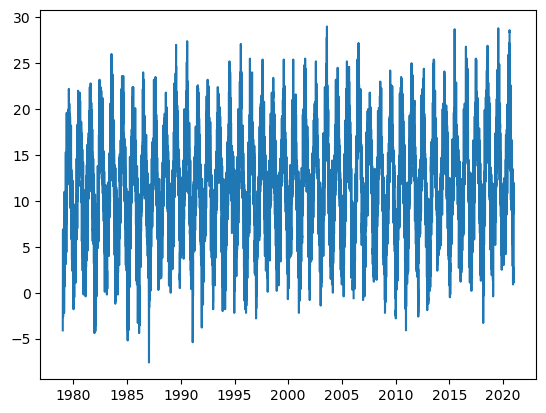

In [8]:
plt.plot(df.index, df['mean_temp'])

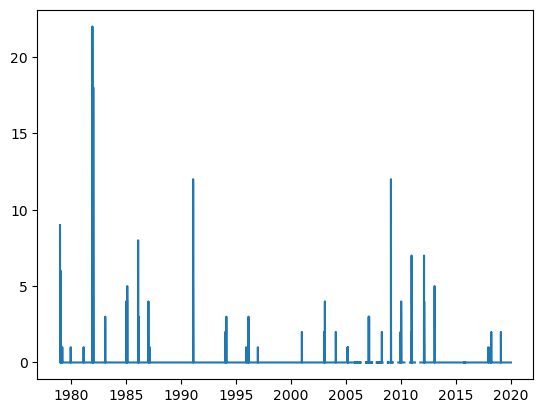

In [9]:
plt.plot(df.index, df['snow_depth'])

In [10]:
# Count NaN values in each column
nan_counts = df.isna().sum()

for col, count in nan_counts.items():
    print(f'{col}: {count}')

mean_temp: 37
max_temp: 6
min_temp: 2
cloud_cover: 19
sunshine: 0
global_radiation: 19
precipitation: 6
pressure: 4
snow_depth: 1441


In [11]:
df = df.dropna()

print(df.shape)

(13843, 9)


In [12]:
split_ratio = 13849 * 8//10
print(split_ratio)

11079


In [13]:
df_train = df[:split_ratio]
df_test = df[split_ratio:]

In [14]:
y_test = df_test['mean_temp'].values

In [15]:
y_test

array([19.1, 19.1, 16.8, ...,  8.1,  8.7,  6.5])

# Data preprocessing

In [16]:
# Create a scaling object
scaler = StandardScaler()

# Fit scaler to data
scaler.fit(df)

# Scale everything
scaled_data = scaler.fit_transform(df)

In [17]:
scaled_data.shape

(13843, 9)

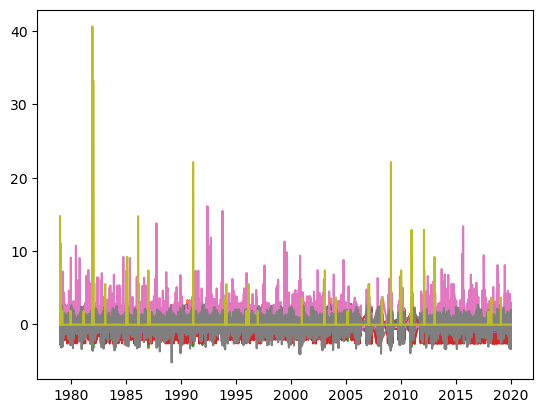

In [18]:
plt.plot(df.index, scaled_data)
plt.show()

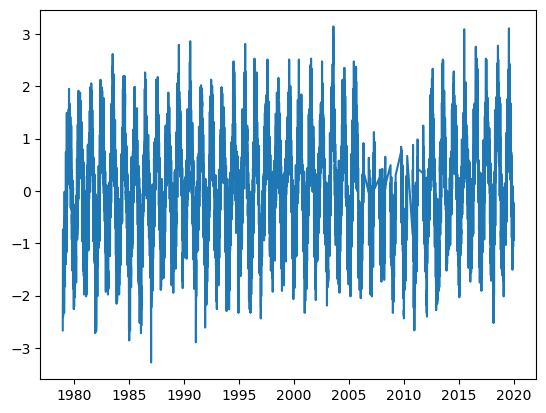

In [19]:
plt.plot(df.index, scaled_data[:,0])

Note that the errant 35+ data comes from the snowfall, which we will keep in our data for now and see if that impacts the training of our model

In [20]:
# Create the training and testing data using an 80-20 split
X_train = scaled_data[:split_ratio, 1:]
y_train = scaled_data[:split_ratio, 0]

X_test = scaled_data[split_ratio:, 1:]
y_test = scaled_data[split_ratio:, 0]

In [21]:
model = Sequential([
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(1)
])

In [22]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

In [23]:
history = model.fit(X_train, y_train, epochs = 50)

Epoch 1/50
347/347 [==============================] - 2s 1ms/step - loss: 0.1331 - mean_absolute_error: 0.2783
Epoch 2/50
347/347 [==============================] - 0s 1ms/step - loss: 0.1052 - mean_absolute_error: 0.2529
Epoch 3/50
347/347 [==============================] - 0s 1ms/step - loss: 0.1003 - mean_absolute_error: 0.2494
Epoch 4/50
347/347 [==============================] - 0s 1ms/step - loss: 0.0980 - mean_absolute_error: 0.2459
Epoch 5/50
347/347 [==============================] - 0s 1ms/step - loss: 0.0983 - mean_absolute_error: 0.2458
Epoch 6/50
347/347 [==============================] - 0s 1ms/step - loss: 0.0987 - mean_absolute_error: 0.2467
Epoch 7/50
347/347 [==============================] - 0s 1ms/step - loss: 0.0971 - mean_absolute_error: 0.2451
Epoch 8/50
347/347 [==============================] - 0s 1ms/step - loss: 0.0958 - mean_absolute_error: 0.2432
Epoch 9/50
347/347 [==============================] - 0s 1ms/step - loss: 0.0956 - mean_absolute_error: 0.2432
E

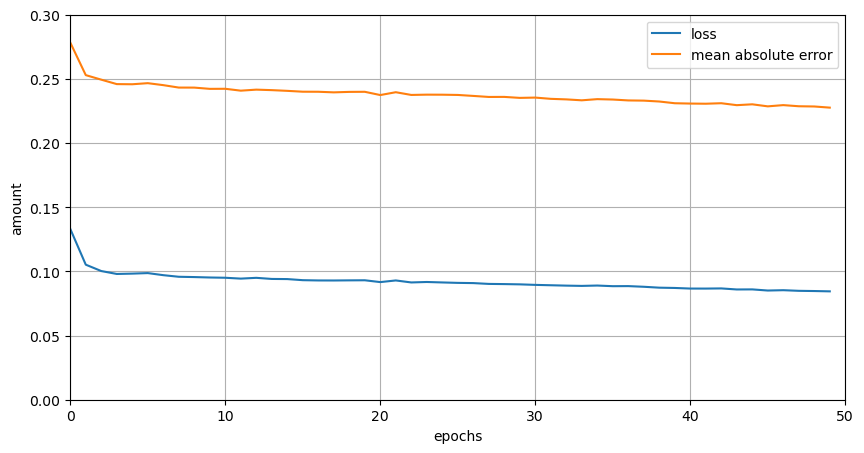

In [26]:
plt.figure(figsize = (10,5))
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['mean_absolute_error'], label = 'mean absolute error')
plt.xlabel('epochs')
plt.ylabel('amount')
plt.ylim(0,0.3)
plt.xlim(0,50)
plt.grid(True)
plt.legend()

In [27]:
model.evaluate(X_test, y_test)

87/87 [==============================] - 0s 1ms/step - loss: 0.1266 - mean_absolute_error: 0.2704


[0.12659822404384613, 0.27038493752479553]

In [41]:
y_pred_on_test = model.predict(X_test)


# Data post processing
y_sim = np.zeros(shape = (len(y_pred_on_test), df.shape[1]))
# assign predicted values in the right field
y_sim[:,0] = y_pred_on_test[:, 0]
# Unscale
y_pred_on_test = scaler.inverse_transform(y_sim)[:,0]
y_pred_on_test = np.reshape(y_pred_on_test, (len(y_pred_on_test), 1))

# We now need to shift the data back by one, since it was trained to predict the next days data
y_pred_on_test = y_pred_on_test[:-1]

87/87 [==============================] - 0s 797us/step


In [43]:
print(len(X_test))
print(len(y_pred_on_test))

2764
2763


In [44]:
# Unscale the actual data

# Create an empty dataset
sim = np.zeros(shape = (len(X_test), df.shape[1]))
# Assign the values to the correct field
sim[:,0] = y_test[:]
sim[:,1:] = X_test[:,:]
# Unscale the data
unscaled = scaler.inverse_transform(sim)

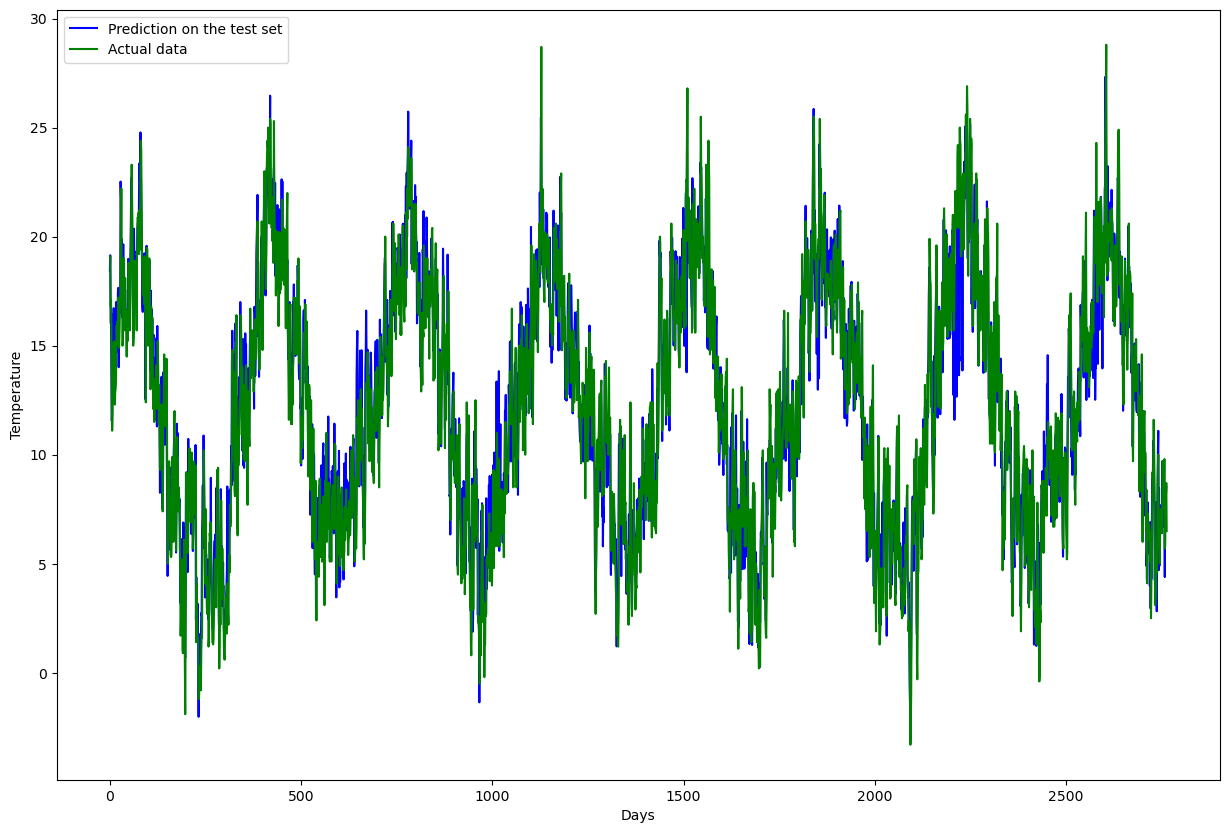

In [45]:
plt.figure(figsize = (15,10))
plt.plot(y_pred_on_test, color = 'b', label = 'Prediction on the test set')
plt.plot(unscaled[:,0], color = 'g', label = 'Actual data')
plt.xlabel('Days')
plt.ylabel('Temperature')
plt.legend()
plt.show()

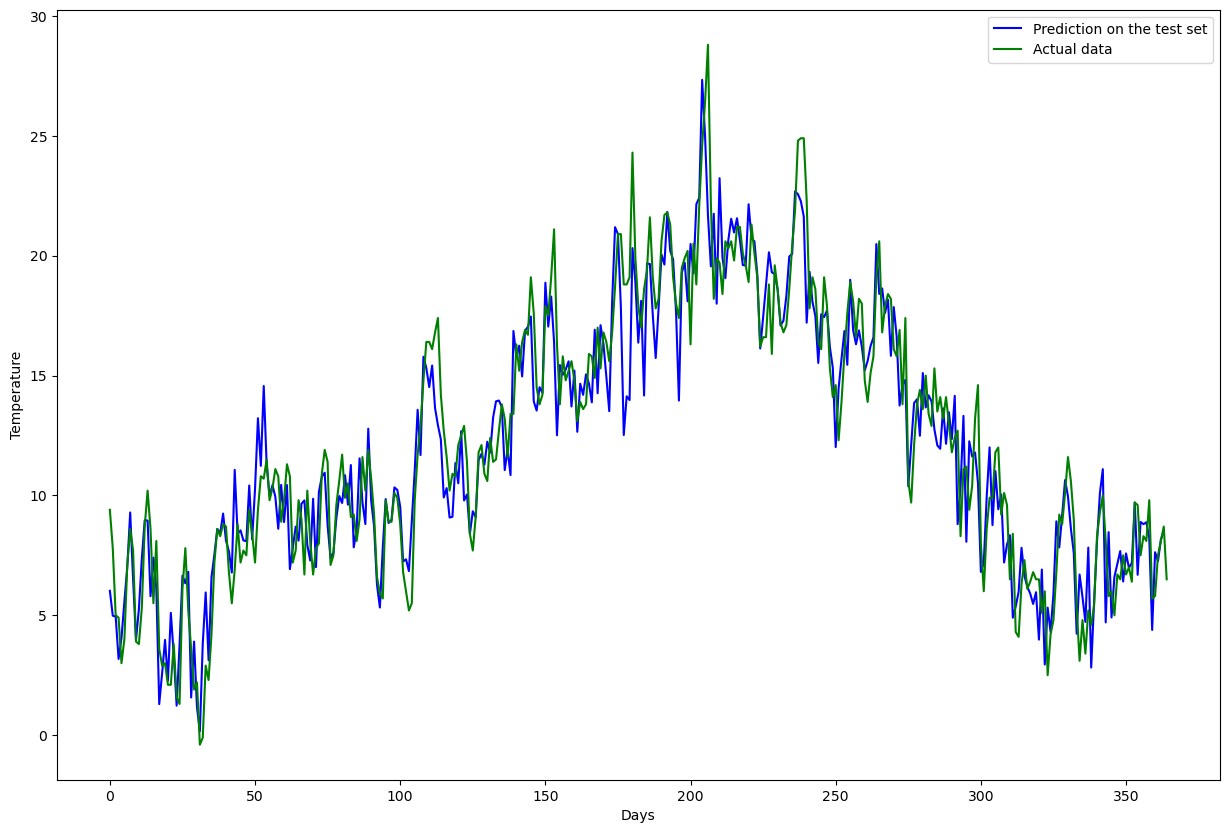

In [46]:
plt.figure(figsize = (15,10))
plt.plot(y_pred_on_test[(2764-365):], color = 'b', label = 'Prediction on the test set')
plt.plot(unscaled[(2764-365):,0], color = 'g', label = 'Actual data')
plt.xlabel('Days')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Altering parameters

In [51]:
# Define the hyperparameters to search over
hidden_layers = [2, 3, 4, 5]
hidden_units = [16, 32, 64, 128]
activation_func = ['tanh', 'relu', 'leakyrelu']
alpha = [0.01, 0.25, 0.5, 0.75, 1]
learning_rate = [0.2, 0.1, 0.075, 0.5]

# Create a list of all possible hyperparameter combinations
param_grid = itertools.product(hidden_layers, hidden_units, activation_func, alpha, learning_rate)

In [48]:
# units = [16,32,64,128]
# layers = [2,3,4,5]

In [54]:
# Define a function to create and train a model with a given set of hyperparameters
def create_model(hidden_layers, hidden_units, activation_func, alpha, learning_rate):
    model = Sequential()
    for i in range(hidden_layers):
        if activation_func == 'leakyrelu':
            model.add(Dense(hidden_units))
            model.add(LeakyReLU(alpha=alpha))
        else:
            model.add(Dense(hidden_units))
    model.add(Dense(1, activation = 'softmax'))
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mean_absolute_error'])
    model.fit(X_train, y_train, epochs = 50)
    loss, mean_absolute_error = model.evaluate(X_test, y_test)
    return loss, mean_absolute_error

In [57]:
results = []

for params in param_grid:
    loss, accuracy = create_model(*params)
    results.append((params, loss, accuracy))